## Spatial wavefield gradient-based seismic wavefield separation

### 03 P/S separation of synthetic OBC data

P/S separation based on the elastodynamic representation theorem using spatial wavefield gradients can be applied to OBC data. Similar to the land seismic case, we interpret the horizontal particle velocity component of the upgoing S-wave constituents and the vertical particle velocity component of the upgoing P-wave constituents (see Van Renterghem et al. (2018) for details):

$$
v_x^{S^U} \approx \frac{1}{\rho \beta}(\nabla \times v^U)_y \approx \frac{1}{2} (v_x - \frac{1}{i\omega} 2\beta \frac{\partial v_z}{\partial x} + \frac{1}{i\omega} \frac{1}{\rho} \frac{\partial p}{\partial x})
$$

$$
v_y^{S^U} \approx \frac{1}{\rho \beta}(\nabla \times v^U)_x \approx \frac{1}{2} (v_y - \frac{1}{i\omega} 2\beta \frac{\partial v_z}{\partial y} + \frac{1}{i\omega} \frac{1}{\rho} \frac{\partial p}{\partial y})
$$

$$
v_z^{P^U} \approx \frac{1}{\rho \alpha}(\nabla \cdot v) \approx \frac{1}{2} (v_z + \frac{1}{i\omega} \frac{2\beta^2}{\alpha} (\frac{\partial v_x}{\partial x} + \frac{\partial v_y}{\partial y}) - \frac{1}{\alpha \rho}p)
$$

This notebook illustrates the P/S separation method on a synthetic OBC data example. The seismograms (.mat file) were generated from a 2D model consisting of a 100 m thick water layer bounded above by a free-surface. Below the water layer is a homogeneous medium with a P-wave velocity of 1800 m/s, an S-wave velocity of 700 m/s and a density of 1600 kg/m$^{3}$. A point source emitting a 50 Hz Ricker wavelet was placed at 100 m below the seafloor to generate both P- and S-waves.

In [1]:
# import libraries 
# ----------------
%matplotlib notebook
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# check .mat file 
# ---------------
from scipy.io import whosmat
whosmat('OBC_synthetic_data_PS_resample.mat') # to list variables inside mat file

[('vx', (3000, 600), 'double'),
 ('vz', (3000, 600), 'double'),
 ('pressure', (3000, 600), 'double')]

In [3]:
# load .mat file 
# --------------
from scipy.io import loadmat
mat = loadmat('OBC_synthetic_data_PS_resample.mat')  # to load mat file
# convert them to numpy array
vx = mat['vx']
vz = mat['vz']
pressure = mat['pressure']
mat = 0

In [4]:
# initialize parameters 
# ---------------------
nx = vx.shape[1] # number of cells in x direction
dx = 1           # cell size
dt = 1e-4        # time step
alpha = 1800     # P-wave velocity
beta = 700       # S-wave velocity
rho = 1600       # density

In [5]:
# calculate wavefield gradients 
# -----------------------------
from fd_weights import *
c = fd_weights(0, [-3/2, -1/2, 1/2, 3/2], 1) # FD coefficients according to Fornberg (1988)

# allocate zero gradients
gradx_vx       = np.zeros((      vx.shape[0],nx))
gradx_vz       = np.zeros((      vz.shape[0],nx))
gradx_pressure = np.zeros((pressure.shape[0],nx))

for n in range(2,(vx.shape[1]-2)):
    # horizontal gradients of vx
    gradx_vx[:,n] = ((c[0]*vx[:,n-1]) + (c[1]*vx[:,n])   + (c[2]*vx[:,n+1]) + (c[3]*vx[:,n+2])) / dx
    # horizontal gradients of vz
    gradx_vz[:,n] = ((c[0]*vz[:,n-2]) + (c[1]*vz[:,n-1]) + (c[2]*vz[:,n])   + (c[3]*vz[:,n+1])) / dx
    # horizontal gradient of pressure
    gradx_pressure[:,n] = ((c[0]*pressure[:,n-2]) + (c[1]*pressure[:,n-1]) \
                         + (c[2]*pressure[:,n])   + (c[3]*pressure[:,n+1])) / dx
    
# P/S separation 
# --------------
# upgoing P-wave on vz
vz_P_up = (1/2.) * (vz + ((beta*((2*beta)/alpha)) * (gradx_vx.cumsum(axis=0)*dt)) - ((1/(alpha * rho)) * pressure))
# upgoing S-wave on vx
vx_S_up = (1/2.) * (vx - ((2*beta) * (gradx_vz.cumsum(axis=0)*dt)) + ((1/rho) * (gradx_pressure.cumsum(axis=0)*dt)))

<IPython.core.display.Javascript object>


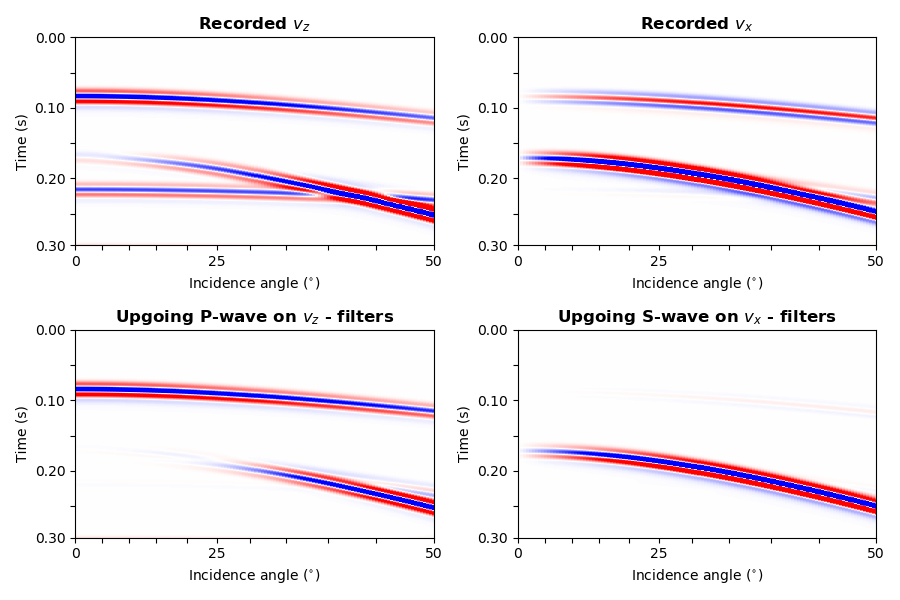

In [6]:
# plotting configuration 
# ----------------------
plt.figure(figsize=(9, 6))

# recorded vz
plt.subplot(2,2,1)
vm1 = np.percentile(vz, 99)
plt.imshow(-vz, cmap="bwr", vmin=-vm1, vmax=vm1, aspect='auto')
plt.xlim(1200/4,1676/4)
plt.ylim(59000/20,0)
plt.title('Recorded $v_z$',fontweight="bold")
plt.xlabel('Incidence angle ($^{\circ}$)')
plt.ylabel('Time (s)')
plt.xticks([1200/4,1236/4,1272/4,1308/4,1348/4,1388/4,1432/4,1480/4,1536/4,1600/4,1676/4],['0','','','','','25','','','','','50'])
plt.yticks([0,10000/20,20000/20,30000/20,40000/20,50000/20,59000/20],['0.00','','0.10','','0.20','','0.30'])

# P/S separated upgoing vz
plt.subplot(2,2,3)
vm2 = np.percentile(vz_P_up, 99)
plt.imshow(-vz_P_up, cmap="bwr", vmin=-vm2, vmax=vm2, aspect='auto')
plt.xlim(1200/4,1676/4)
plt.ylim(59000/20,0)
plt.title('Upgoing P-wave on $v_z$ - filters',fontweight="bold")
plt.xlabel('Incidence angle ($^{\circ}$)')
plt.ylabel('Time (s)')
plt.xticks([1200/4,1236/4,1272/4,1308/4,1348/4,1388/4,1432/4,1480/4,1536/4,1600/4,1676/4],['0','','','','','25','','','','','50'])
plt.yticks([0,10000/20,20000/20,30000/20,40000/20,50000/20,59000/20],['0.00','','0.10','','0.20','','0.30'])

# recorded vx
plt.subplot(2,2,2)
vm3 = np.percentile(vx, 99)
plt.imshow(-vx, cmap="bwr", vmin=-vm3, vmax=vm3, aspect='auto')
plt.xlim(1200/4,1676/4)
plt.ylim(59000/20,0)
plt.title('Recorded $v_x$',fontweight="bold")
plt.xlabel('Incidence angle ($^{\circ}$)')
plt.ylabel('Time (s)')
plt.xticks([1200/4,1236/4,1272/4,1308/4,1348/4,1388/4,1432/4,1480/4,1536/4,1600/4,1676/4],['0','','','','','25','','','','','50'])
plt.yticks([0,10000/20,20000/20,30000/20,40000/20,50000/20,59000/20],['0.00','','0.10','','0.20','','0.30'])

# P/S separated upgoing vx
plt.subplot(2,2,4)
vm4 = np.percentile(vx_S_up, 99)
plt.imshow(-vx_S_up, cmap="bwr", vmin=-vm4, vmax=vm4, aspect='auto')
plt.xlim(1200/4,1676/4)
plt.ylim(59000/20,0)
plt.title('Upgoing S-wave on $v_x$ - filters',fontweight="bold")
plt.xlabel('Incidence angle ($^{\circ}$)')
plt.ylabel('Time (s)')
plt.xticks([1200/4,1236/4,1272/4,1308/4,1348/4,1388/4,1432/4,1480/4,1536/4,1600/4,1676/4],['0','','','','','25','','','','','50'])
plt.yticks([0,10000/20,20000/20,30000/20,40000/20,50000/20,59000/20],['0.00','','0.10','','0.20','','0.30'])

# show result on screen
plt.tight_layout()
plt.show()

The figures above show the total horizontal and vertical particle velocity recordings at the seafloor and the P/S separated results. Our technique effectively suppresses the horizontal component of the P-wave and the vertical component of the S-wave up to moderate incidence angles. The sea surface multiple (receiver ghost), which is observed on the vertical component at about 0.21 s, has also been removed by the combined up/down and P/S separation.